# Преобразование картинок перед загрузкой в сетку

In [1]:
from torch.utils.data import DataLoader, Dataset
import PIL
from PIL import Image
import torch
from torchvision import transforms

In [2]:
from skimage.io import imread
import numpy
from matplotlib import pyplot as plt
import numpy as np
import os

path_image = r'C:\Users\yalox\Documents\Experiments_with_images\pict\pict_final'
path_lesion = r'C:\Users\yalox\Documents\Experiments_with_images\image'
filelist_image = os.listdir(path_image)
filelist_lesion = os.listdir(path_lesion)

images = []
lesions = []

#gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114]) 

for i in filelist_image:
    if i.endswith(".bmp"):
        images.append(imread(path_image + '\\' + i))
for j in filelist_lesion:
    if j.endswith(".bmp"):
        lesions.append(imread(path_lesion + '\\' + j))

In [3]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=False) > 0.5 for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=True) for y in lesions]

In [4]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 1875 images


Проверим, всё ли правильно мы загрузили

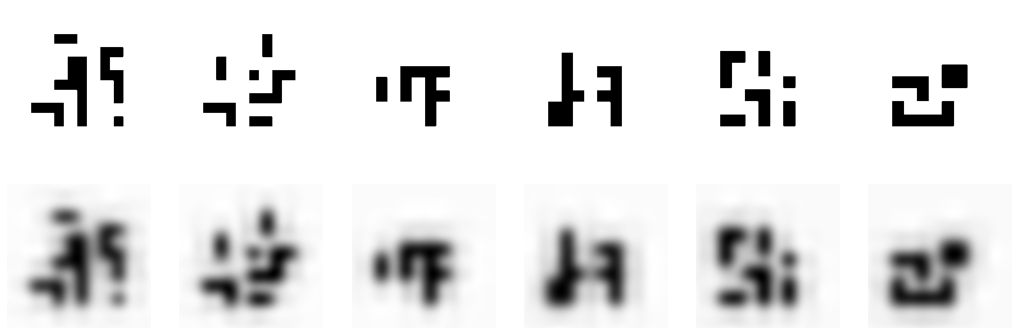

In [5]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим данные на обучающую, валидационную и тестовую части

In [6]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [1300, 1600])
print(len(tr), len(val), len(ts))

1300 300 275


In [7]:
batch_size = 8
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), np.rollaxis(Y[tr], 3, 1))), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), np.rollaxis(Y[val], 3, 1))),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), np.rollaxis(Y[ts], 3, 1))),
                     batch_size=batch_size, shuffle=True)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Определим функцию train

In [9]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler=None, visualize=True):
    X_val, Y_val = next(iter(data_val))
    losses=[]
    val_losses=[]
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        if scheduler is not None:
          scheduler.step()
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch) 
            #print(Y_batch.shape, Y_pred.shape)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        losses.append(avg_loss)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).cpu().detach()# detach and put into cpu
        print(loss_fn(Y_val, Y_hat))
        val_losses.append(loss_fn(Y_val, Y_hat))
        Y_hat = Y_hat.numpy()
        # Visualize tools
        clear_output(wait=True)
        if visualize:
          for k in range(4):
              plt.subplot(4, 4, k+1)
              plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
              plt.title('Real')
              plt.axis('off')

              plt.subplot(4, 4, k+5)
              plt.imshow(np.rollaxis(Y_val[k].numpy(), 0, 3), cmap='gray')
              plt.title('Real mask')
              plt.axis('off')

              plt.subplot(4, 4, k+9)
              plt.imshow(Y_hat[k, 0], cmap='gray')
              plt.title('Output')
              plt.axis('off')

              plt.subplot(4, 4, k+13)
              plt.imshow(Y_hat[k, 0]>0.37, cmap='gray')
              plt.title('Binary Output')
              plt.axis('off')

          plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
          plt.show()
    return losses, val_losses

Определим функцию для оценки качества модели

In [10]:
 def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    count = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch)
        Y_pred_np = model(X_batch.to(device)).cpu().detach().numpy()
        if count < 1 :
            for k in range(4):
                  plt.subplot(2, 4, k+1)
                  plt.imshow(np.rollaxis(Y_label[k].numpy(), 0, 3), cmap='gray')
                  plt.title('Real image')
                  plt.axis('off')

                  plt.subplot(2, 4, k+5)
                  plt.imshow(Y_pred_np[k, 0], cmap='gray')
                  plt.title('Output')
                  plt.axis('off')
            plt.show()
        count += 1
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (25,6)
np.random.seed(0)
torch.manual_seed(0)

torch.backends.cudnn.determenistic = True

Архитектура сетки выглядит так:

In [12]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(kernel_size=2) # 256 -> 128
        self.enc_conv1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, padding_mode='replicate')
        self.batchnorm0 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        self.bottleneck_conv = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, padding_mode='replicate')

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(size = 32, mode='bilinear') # 16 -> 32
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1, padding_mode='replicate')
        self.upsample1 = nn.Upsample(size = 64, mode='bilinear') # 32 -> 64
        self.dec_conv1 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1, padding_mode='replicate')
        self.upsample2 = nn.Upsample(size = 128, mode='bilinear')  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, padding_mode='replicate')
        self.upsample3 = nn.Upsample(size = 256, mode='bilinear')  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=3, kernel_size=3, padding=1, padding_mode='replicate')

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x))) #128
        e1 = self.pool1(F.relu(self.enc_conv1(e0))) #64
        e2 = self.pool2(F.relu(self.enc_conv2(e1))) #32x128
        e3 = self.pool3(F.relu(self.enc_conv3(e2))) #16

        # bottleneck
        b = self.bottleneck_conv(F.relu(e3))

        # decoder
        d0 = self.dec_conv0(F.relu(self.upsample0(b)))#32x256
        d1 = self.dec_conv1(F.relu(self.upsample1(self.dec_conv0(torch.cat((e2, d0), dim=1)))))#64
        d2 = self.dec_conv2(F.relu(self.upsample2(self.dec_conv1(torch.cat((e1, d1), dim=1)))))#128
        d3 = self.dec_conv3(self.upsample3(self.dec_conv2(torch.cat((e0, d2), dim=1))))  # no activation
        return d3

In [13]:
unet_model = UNet().to(device)

Обучаем U-Net с функцией потерь MAELoss

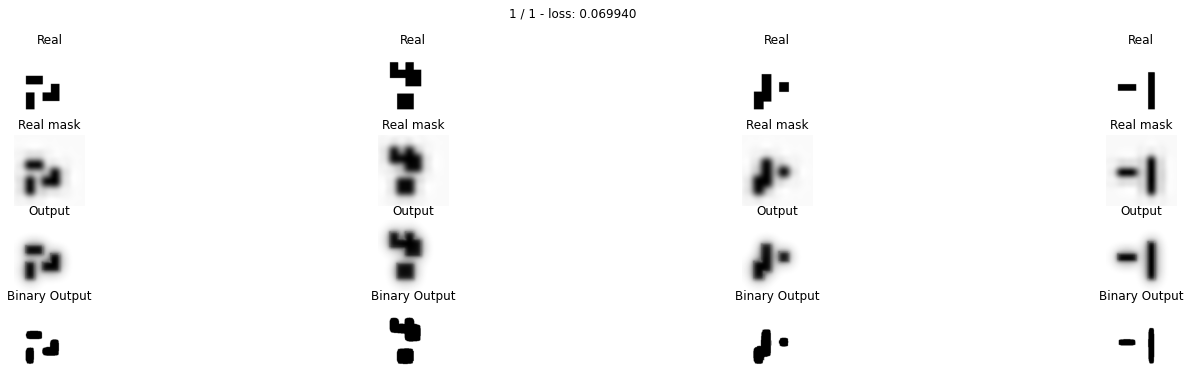

In [33]:
optimizer = optim.Adam(unet_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
unet_losses_tr, unet_losses_val = train(unet_model, optimizer, nn.L1Loss(), 1, data_tr, data_val, scheduler)

In [34]:
unet_model.eval()
image_time = [resize(imread(r'C:\Users\yalox\Documents\Experiments_with_images\pict\pict_final\5-5.bmp'),size, mode='constant', anti_aliasing=False)]
image_time = torch.Tensor(np.rollaxis(np.array(image_time, np.float32), 3, 1)).to(device)


In [35]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
starter.record()
Y_hat = unet_model(image_time)
ender.record()
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print('time for one image', curr_time)


time for one image 28.914976119995117


(-0.5, 255.5, 255.5, -0.5)

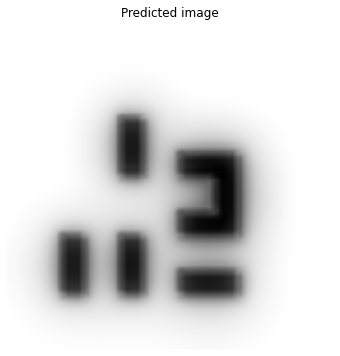

In [36]:
plt.imshow(Y_hat.cpu().detach().numpy()[0,0], cmap = "gray")
plt.title('Predicted image')
plt.axis('off')

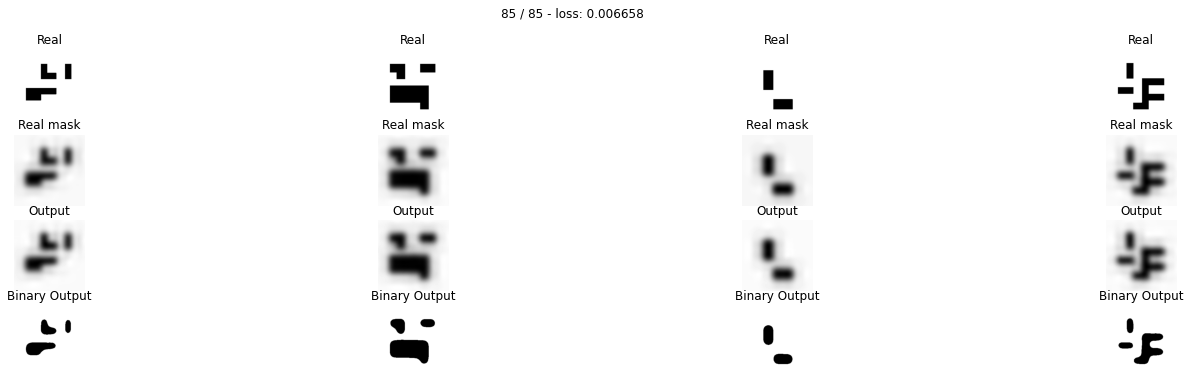

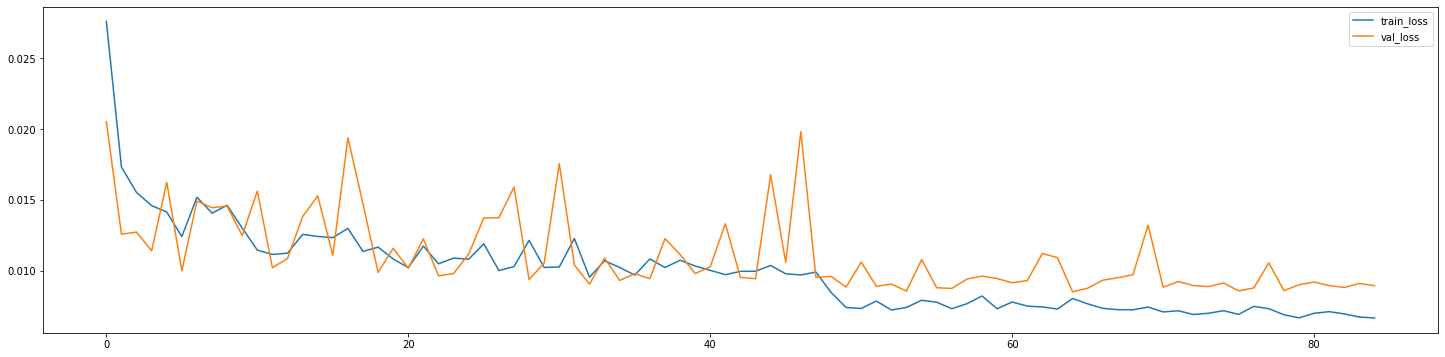

In [37]:
optimizer = optim.Adam(unet_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
unet_losses_tr, unet_losses_val = train(unet_model, optimizer, nn.L1Loss(), 85, data_tr, data_val, scheduler)
plt.plot(unet_losses_tr, label='train_loss')
plt.plot(unet_losses_val, label='val_loss')
plt.legend()

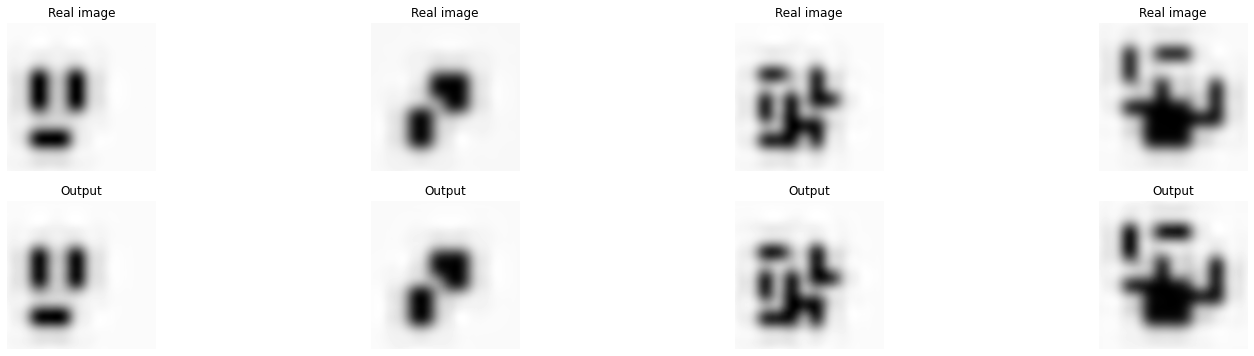

Loss on the test data:  0.00881413689681462


In [38]:
scores = score_model(unet_model, nn.L1Loss(), data_ts)
print("Loss on the test data: ", scores)

In [39]:
unet_model.eval()
image_time = [resize(imread(r'C:\Users\yalox\Documents\Experiments_with_images\pict\pict_final\5-5.bmp'),size, mode='constant', anti_aliasing=False)]
image_time = torch.Tensor(np.rollaxis(np.array(image_time, np.float32), 3, 1)).to(device)


In [40]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
starter.record()
Y_hat = unet_model(image_time)
ender.record()
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print('time for one image', curr_time)


time for one image 8.745408058166504


(-0.5, 255.5, 255.5, -0.5)

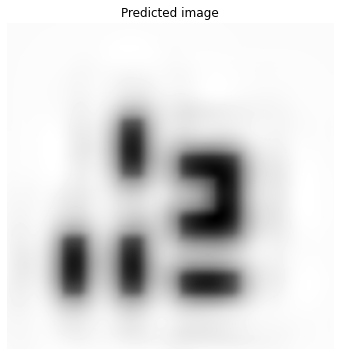

In [41]:
plt.imshow(Y_hat.cpu().detach().numpy()[0,0], cmap = "gray")
plt.title('Predicted image')
plt.axis('off')

Обучаем U-Net с функцией потерь MSELoss

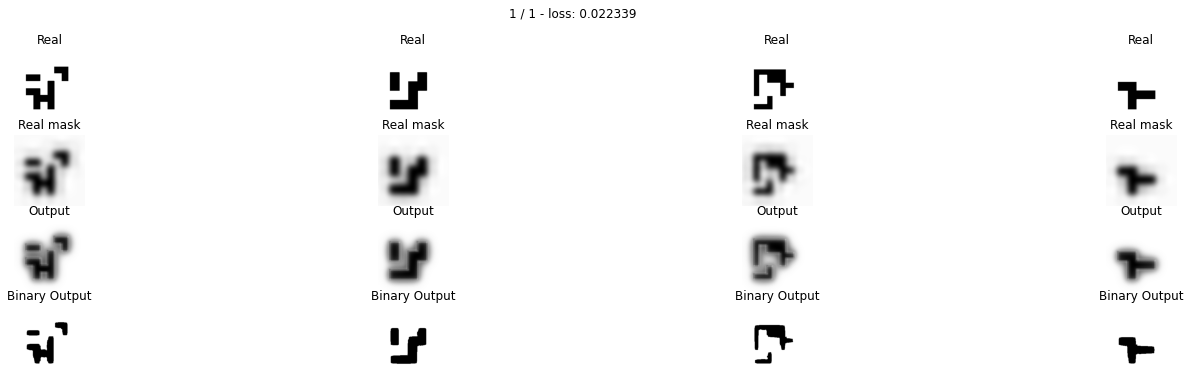

In [14]:
optimizer = optim.Adam(unet_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
unet_losses_tr, unet_losses_val = train(unet_model, optimizer, nn.MSELoss(), 1, data_tr, data_val, scheduler)

In [15]:
unet_model.eval()
image_time = [resize(imread(r'C:\Users\yalox\Documents\Experiments_with_images\pict\pict_final\5-5.bmp'),size, mode='constant', anti_aliasing=False)]
image_time = torch.Tensor(np.rollaxis(np.array(image_time, np.float32), 3, 1)).to(device)


In [16]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
starter.record()
Y_hat = unet_model(image_time)
ender.record()
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print('time for one image', curr_time)


time for one image 10.373600006103516


(-0.5, 255.5, 255.5, -0.5)

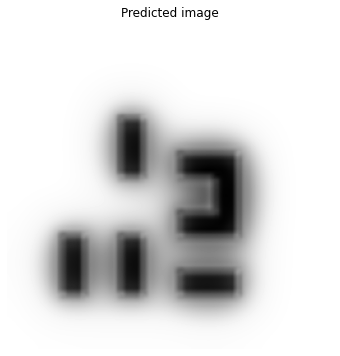

In [17]:
plt.imshow(Y_hat.cpu().detach().numpy()[0,0], cmap = "gray")
plt.title('Predicted image')
plt.axis('off')

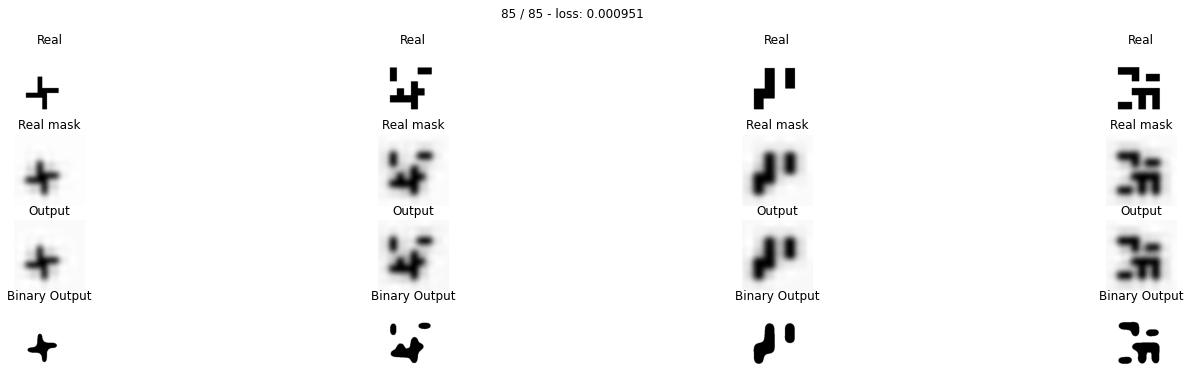

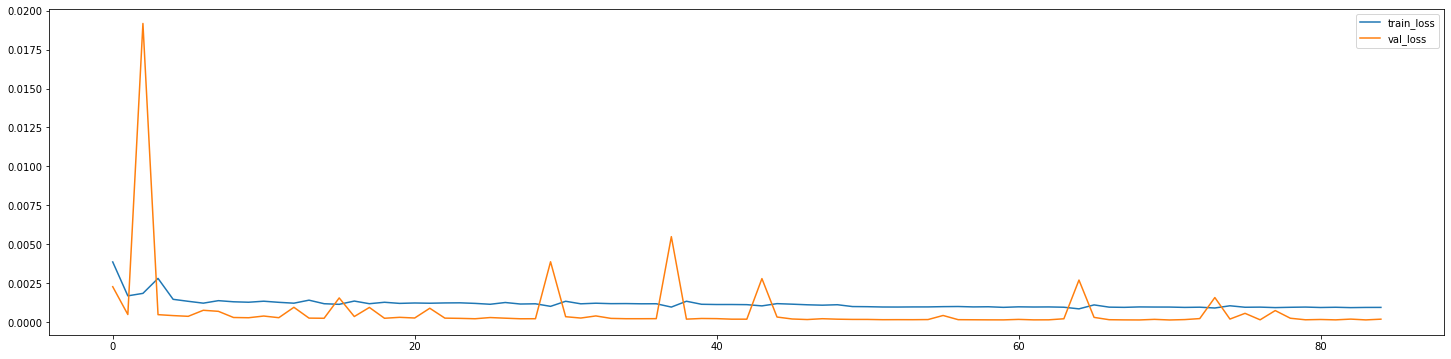

In [18]:
optimizer = optim.Adam(unet_model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
unet_losses_tr, unet_losses_val = train(unet_model, optimizer, nn.MSELoss(), 85, data_tr, data_val, scheduler)
plt.plot(unet_losses_tr, label='train_loss')
plt.plot(unet_losses_val, label='val_loss')
plt.legend()

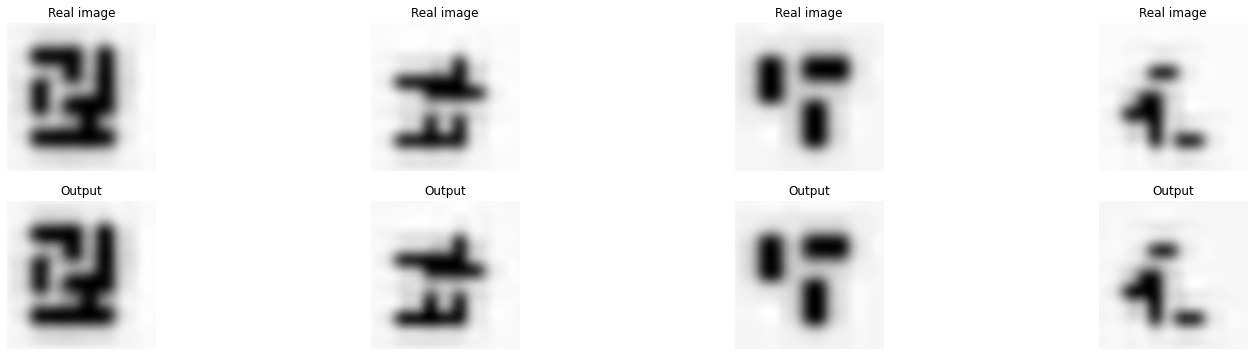

Loss on the test data:  0.00019177274620493077


In [19]:
scores = score_model(unet_model, nn.MSELoss(), data_ts)
print("Loss on the test data: ", scores)

Измерим время, за которое сетка делает предсказание для одной картинки

In [20]:
unet_model.eval()
image_time = [resize(imread(r'C:\Users\yalox\Documents\Experiments_with_images\pict\pict_final\5-5.bmp'),size, mode='constant', anti_aliasing=False)]
image_time = torch.Tensor(np.rollaxis(np.array(image_time, np.float32), 3, 1)).to(device)

In [21]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
starter.record()
Y_hat = unet_model(image_time)
ender.record()
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender)
print('time for one image', curr_time)


time for one image 8.444735527038574


(-0.5, 255.5, 255.5, -0.5)

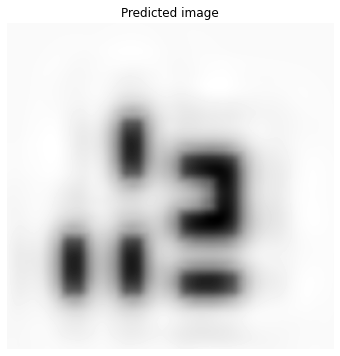

In [22]:
plt.imshow(Y_hat.cpu().detach().numpy()[0,0], cmap = "gray")
plt.title('Predicted image')
plt.axis('off')